## Imports and initializations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Earthquake\ Shelter\ Project

Mounted at /content/drive
/content/drive/MyDrive/Earthquake Shelter Project


In [ ]:
import os
import csv
import pickle
import datetime
import urllib.parse
from math import radians, sin, cos, sqrt, atan2
from decimal import Decimal, getcontext
getcontext().prec = 10

In [ ]:
import pandas as pd
import numpy as np

import geopandas as gpd
import folium
import networkx as nx
from pyproj import Proj, transform
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from shapely.geometry import Point
from geopy.geocoders import Nominatim

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
def read_pickle(dataset_name):
  with open('data/' + dataset_name + '.pkl', 'rb') as file_:
    return pickle.load(file_)

**Hazard** - potential of an earthquake to produce harm
- magnitude and epicenter of earthquakes (distances to epicenter could work well as a matrix for a CNN, or as edge weights)

**Exposure** - amount of population exposed to harm
- population of the area

**Vulnerability** - proneness of the infrastructure to suffer damages
- land usage
- distance to nearest water body
- number of buildings, how old the buildings are


**Hazard**
- 気象庁 震度データベース

**Exposure**
- 1kmメッシュ別将来推計人口 (H30国政局推計) (shape形式版)

**Vulnerability**
- 土地利用細分メッシュデータ



In [ ]:
prefecture = 'tokyo'
base_filepath = f'data/prefectural_data/{prefecture}/'
# prefecture = 'aichi'
# base_filepath = ''

## Shelter Data

Source: https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-P20.html

In [ ]:
gdf = gpd.read_file(base_filepath + 'shelters.dbf')
gdf = gdf.rename(columns={**{
    f'P20_0{str(i + 1).zfill(2)}': el for i, el in enumerate([
        'municality_code', 'name', 'address', 'type', 'capacity', 'area', # area of shelter in square meters
        'earthquake', 'tsunami', 'water_damage', 'volcano', 'other', 'not_specified'
    ])
}, **{
    'レベル': 'level', '備考': 'notes', '緯度': 'latitude', '経度': 'longitude', 'NO': 'num'
}})

ERROR:fiona._env:fread(1360) failed on DBF file.


In [ ]:
boolean_cols = ['earthquake', 'tsunami', 'water_damage', 'volcano', 'other', 'not_specified']
gdf[boolean_cols] = gdf[boolean_cols].astype(bool)

In [ ]:
gdf

,municality_code,name,address,type,capacity,area,earthquake,tsunami,water_damage,volcano,other,not_specified,level,notes,latitude,longitude,num,geometry
0,23101,なごやかハウス希望ヶ丘,愛知県名古屋市千種区希望ヶ丘二丁目3-9,避難所、福祉避難所,-1,-1,False,False,False,False,False,True,1,None,35.178201,136.969123,1,None
1,23101,愛知学院,愛知県名古屋市千種区楠元町1-100,避難所,-1,-1,False,False,False,False,False,True,1,None,35.167758,136.960846,2,None
2,23101,愛知工業大学名電高校南側校舎,愛知県名古屋市千種区若水三丁目2-12,避難所,-1,-1,False,False,False,False,False,True,1,None,35.177673,136.947958,3,None
3,23101,愛知工業大学名電高校北側校舎,愛知県名古屋市千種区北千種三丁目4-35,避難所,-1,-1,False,False,False,False,False,True,1,None,35.178673,136.949152,4,None
4,23101,愛知淑徳学園,愛知県名古屋市千種区桜が丘23,避難所,-1,-1,False,False,False,False,False,True,1,None,35.166512,136.987712,5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,23216,小鈴谷保育園分園,愛知県常滑市坂井字中山25-2,避難所,-1,-1,False,False,False,False,False,True,1,None,34.816960,136.868087,3137,None
3079,23216,小鈴谷北保育園園庭,愛知県常滑市大谷字井戸尻13,一時避難場所,-1,-1,False,False,False,False,False,True,1,None,34.836819,136.870169,3138,None
3080,23216,松籟荘,愛知県常滑市多屋字南釜谷5-1,避難所、福祉避難所,-1,-1,False,False,False,False,False,True,1,None,34.900816,136.840310,3139,None
3081,23216,上ノ山農村公園,愛知県常滑市矢田字上之山101,一時避難場所,-1,-1,False,False,False,False,False,True,3,None,34.935489,136.858930,3140,None


In [ ]:
gdf['prefecture'] = prefecture

In [ ]:
# shelters = pd.concat([shelters, gdf], ignore_index=True)
shelters = gdf
shelters.shape

(3083, 19)

In [ ]:
# shelters.to_pickle('data/shelters.pkl')

In [ ]:
# shelters = read_pickle('shelters')

In [ ]:
# gdf_with_capacity = gdf[gdf['capacity'] != -1]
# gdf_with_capacity.head()

## Population Data (for 1km meshes)

作成法: https://nlftp.mlit.go.jp/ksj/gml/datalist/mesh500_1000_h30.pdf

Using survey data from 2015, they estimate every 5 years into the future by considering the number of people to turn from one age group to the next; the mortality rates of each group and the birth rates of new 0-4 year olds are also considered.

In [ ]:
# populations = read_pickle('tokyo/population_data_2025')
# populations['prefecture'] = 'tokyo'
# populations

In [ ]:
pop_data = gpd.read_file(base_filepath + 'population.dbf')

In [ ]:
pop_data = pop_data.sort_values(by='MESH_ID')

In [ ]:
# mainland_pop_data = pop_data[(53390000 <= pop_data['MESH_ID']) & (pop_data['MESH_ID'] <= 53397799)]
mainland_pop_data = pop_data
mainland_pop_data

,MESH_ID,SHICODE,PTN_2015,HITOKU2020,GASSAN2020,PTN_2020,PT0_2020,PT1_2020,PT2_2020,PT3_2020,...,PTB_2050,PTC_2050,PTD_2050,PTE_2050,RTA_2050,RTB_2050,RTC_2050,RTD_2050,RTE_2050,geometry
0,51376091,23231,11.9755,None,NaN,11.2602,11.2602,0.5921,0.0000,0.0000,...,4.5991,3.4946,3.4946,2.5448,11.4712,50.3049,38.2239,38.2239,27.8344,None
1,51376092,23231,49.9627,None,NaN,49.8386,49.8386,2.0125,0.0000,0.0000,...,24.2621,14.9200,10.0725,8.4894,7.3105,57.3945,35.2950,23.8276,20.0826,None
2,51376093,23231,198.4554,None,NaN,189.5569,189.5569,6.2139,2.9767,2.9598,...,50.6245,53.7240,44.4108,32.5572,7.8783,44.6927,47.4290,39.2071,28.7424,None
3,51377001,23231,4.9818,None,NaN,4.5338,4.5338,0.2117,0.9949,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,None
4,51377002,23231,74.7216,None,NaN,73.8705,73.8705,2.5326,3.9716,2.9291,...,18.0534,26.7776,17.3900,9.8372,9.0215,36.6369,54.3415,35.2907,19.9633,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,53370030,23215,102.7384,None,NaN,94.4807,94.4807,1.8652,2.0926,1.9782,...,19.6606,25.9648,16.9726,14.4828,7.2495,39.9674,52.7831,34.5031,29.4418,None
3959,53370032,23215,1.0174,None,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,None
3960,53370040,23215,262.4544,None,NaN,244.1863,244.1863,7.0178,7.1684,6.9448,...,81.4981,63.2710,48.0297,34.8046,10.4659,50.4034,39.1307,29.7045,21.5253,None
3961,53370041,23215,5.0157,None,NaN,4.8902,4.8902,0.0000,0.0000,0.0000,...,0.9067,2.5058,1.6505,0.0977,0.0000,26.5689,73.4311,48.3677,2.8632,None


In [ ]:
pop_cols = ['MESH_ID', 'SHICODE', 'PTN_2015', 'PTN_2025', 'PTA_2025', 'PTB_2025', 'PTC_2025', 'PTD_2025', 'PTE_2025']
pop_new_cols = ['mesh_id', 'admin_code', '2015', 'total', '0-14', '15-64', '65+', '75+', '80+']
pop_data_2025 = mainland_pop_data[pop_cols]
pop_data_2025.columns = pop_new_cols[:len(pop_data_2025.columns)]
pop_data_2025['prefecture'] = prefecture

<ipython-input-21-a539bc03b2a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_data_2025['prefecture'] = prefecture


In [ ]:
pop_data_2025

,mesh_id,admin_code,2015,total,0-14,15-64,65+,75+,80+,prefecture
0,51376091,23231,11.9755,10.3920,1.1520,7.4451,1.7948,1.7948,1.7948,aichi
1,51376092,23231,49.9627,49.3347,3.9115,36.4093,9.0139,0.8471,0.0000,aichi
2,51376093,23231,198.4554,177.2314,13.2016,92.0688,71.9610,46.9480,32.7968,aichi
3,51377001,23231,4.9818,4.2682,1.4183,1.8501,0.9998,0.9998,0.9998,aichi
4,51377002,23231,74.7216,72.1030,8.4920,36.3534,27.2576,16.5906,5.1514,aichi
...,...,...,...,...,...,...,...,...,...,...
3958,53370030,23215,102.7384,85.4276,5.5384,36.9019,42.9874,22.3946,15.2843,aichi
3959,53370032,23215,1.0174,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,aichi
3960,53370040,23215,262.4544,227.7849,20.4748,112.0252,95.2849,55.7651,33.3713,aichi
3961,53370041,23215,5.0157,4.8221,0.0000,3.9171,0.9050,0.0000,0.0000,aichi


In [ ]:
# populations = pd.concat([populations, pop_data_2025], ignore_index=True)
populations = pop_data_2025
populations.shape

(3963, 10)

In [ ]:
# populations.to_pickle('data/populations.pkl')

## Land Usage Subdivision Mesh (土地利用細分メッシュデータ)
https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-L03-b-2021.html

In [ ]:
dfs = []

In [ ]:
for filename in sorted(os.listdir()):
    if filename.endswith('.dbf') and 'plot' in filename:
        # filepath = os.path.join('data/prefectural_data/land_use', filename)
        filepath = filename
        print('Reading ', filepath)
        df = gpd.read_file(filepath)
        print(df.shape)
        dfs.append(df)

Reading  plot1.dbf
(6200, 15)
Reading  plot2.dbf
(6400, 15)
Reading  plot3.dbf
(6400, 15)
Reading  plot4.dbf
(6400, 15)


In [ ]:
land_usage_1km_japan = pd.concat(dfs, ignore_index=True)
land_usage_1km_japan

,メッシュ,田,他農用地,森林,荒地,建物用地,道路,鉄道,他用地,河川湖沼,海浜,海水域,ゴルフ場,範囲外,geometry
0,52360600,0,0,0,0,0,0,0,0,0,0,846956,0,211739,None
1,52360601,0,0,0,0,0,0,0,0,0,0,1058704,0,0,None
2,52360602,0,0,0,0,0,0,0,0,0,0,1058714,0,0,None
3,52360603,0,0,0,0,0,0,0,0,0,0,1058724,0,0,None
4,52360604,0,0,0,0,0,0,0,0,0,0,1058734,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395,52375795,0,0,1053679,0,0,0,0,0,0,0,0,0,0,None
25396,52375796,0,0,1053695,0,0,0,0,0,0,0,0,0,0,None
25397,52375797,0,0,1032637,0,0,0,0,0,21074,0,0,0,0,None
25398,52375798,0,0,1053727,0,0,0,0,0,0,0,0,0,0,None


In [ ]:
# corrupted_columns = 14

In [ ]:
# column_headers = land_usage_1km_japan.columns[-corrupted_columns:]
# values = land_usage_1km_japan.iloc[:, :corrupted_columns].values
# land_usage_1km_japan = pd.DataFrame(data=values, columns=column_headers)
# land_usage_1km_japan = land_usage_1km_japan.sort_values(by='メッシュ')
# land_usage_1km_japan

In [ ]:
land_usage_codes = {
    '0100': 'rice_paddy',
    '0200': 'other_agriculture',  # fruits, vegetables, ranches, etc.
    '0500': 'forest',
    '0600': 'wasteland',
    '0700': 'building',
    '0901': 'road_transport',
    '0902': 'rail_transport',
    '1000': 'other_site',         # airports, parks, schools, etc.
    '1100': 'river_wetland',
    '1400': 'seashore',
    '1500': 'sea',
    '1600': 'gold_course',
    '0000': 'unknown'             # failed to analyze the location
}

Convert the standardized mesh codes into latitude and longitude coordinates

https://tech.atware.co.jp/mesh-system/

https://qiita.com/yuusei/items/549402a80efd7e7192ef

https://www.gis-py.com/entry/py-mesh

In [ ]:
def convert_to_latlon(mesh_code):
  # Works for 3D mesh codes only
  # Gets the bottom left corner of the mesh code
  mesh_code = str(mesh_code)

  lat = Decimal(int(mesh_code[0:2])) * Decimal(2) / Decimal(3)
  lon = Decimal(int(mesh_code[2:4])) + Decimal(100)
  lat += Decimal(int(mesh_code[4])) / Decimal(12)
  lon += Decimal(int(mesh_code[5])) / Decimal(8)
  lat += Decimal(int(mesh_code[6])) / Decimal(120)
  lon += Decimal(int(mesh_code[7])) / Decimal(80)

  return round(float(lat), 5), round(float(lon), 5)

In [ ]:
formatted_land_use = pd.DataFrame(columns=[
    'mesh_id', 'latitude', 'longitude',                   # converted using convert_to_latlon (bottom left corner)
    'area',                                               # total area calibrated (in m2)
    'rice_paddy', 'other_agriculture', 'forest',          # categories
    'wasteland', 'building', 'road_transport',
    'rail_transport', 'other_site', 'river_wetland',
    'seashore', 'sea', 'golf_course', 'unknown'
])

In [ ]:
formatted_land_use['mesh_id'] = land_usage_1km_japan['メッシュ']
formatted_land_use[['latitude', 'longitude']] = land_usage_1km_japan['メッシュ'].apply(
    lambda x: pd.Series(convert_to_latlon(x)))
formatted_land_use['area'] = land_usage_1km_japan.iloc[:, 1:14].sum(axis=1)

In [ ]:
for i in range(1, 14):
  formatted_land_use[formatted_land_use.columns[i + 3]] = land_usage_1km_japan[land_usage_1km_japan.columns[i]] / formatted_land_use['area']

In [ ]:
formatted_land_use

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown
0,52360600,34.66667,136.7500,1058695,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.8,0.0,0.2
1,52360601,34.66667,136.7625,1058704,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
2,52360602,34.66667,136.7750,1058714,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
3,52360603,34.66667,136.7875,1058724,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
4,52360604,34.66667,136.8000,1058734,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395,52375795,35.15833,137.9375,1053679,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
25396,52375796,35.15833,137.9500,1053695,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
25397,52375797,35.15833,137.9625,1053711,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0
25398,52375798,35.15833,137.9750,1053727,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [ ]:
# formatted_land_use.to_pickle('data/land_usage.pkl')

In [ ]:
# populations = read_pickle('populations')

## Distance to Water body

In [ ]:
dist_to_water = formatted_land_use
dist_to_water

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown
0,52360600,34.66667,136.7500,1058695,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.8,0.0,0.2
1,52360601,34.66667,136.7625,1058704,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
2,52360602,34.66667,136.7750,1058714,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
3,52360603,34.66667,136.7875,1058724,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
4,52360604,34.66667,136.8000,1058734,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395,52375795,35.15833,137.9375,1053679,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
25396,52375796,35.15833,137.9500,1053695,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
25397,52375797,35.15833,137.9625,1053711,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0
25398,52375798,35.15833,137.9750,1053727,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [ ]:
mask = (dist_to_water['river_wetland'] == 0) & (dist_to_water['seashore'] == 0) & (dist_to_water['sea'] == 0)

In [ ]:
utm_proj = Proj(proj='utm', zone=54, ellps='WGS84') # This zone is for Tokyo, Japan
water_x, water_y = utm_proj(dist_to_water.loc[~mask, 'longitude'].values, dist_to_water.loc[~mask, 'latitude'].values)
check_x, check_y = utm_proj(dist_to_water.loc[mask, 'longitude'].values, dist_to_water.loc[mask, 'latitude'].values)

In [ ]:
distances = cdist(np.vstack((check_x, check_y)).T, np.vstack((water_x, water_y)).T)

In [ ]:
dist_to_water.loc[mask, 'dist_to_water'] = np.min(distances, axis=1)
dist_to_water.loc[~mask, 'dist_to_water'] = 0

In [ ]:
dist_to_water # Distance is measured in meters

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water
0,52360600,34.66667,136.7500,1058695,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.8,0.0,0.2,0.000000
1,52360601,34.66667,136.7625,1058704,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000
2,52360602,34.66667,136.7750,1058714,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000
3,52360603,34.66667,136.7875,1058724,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000
4,52360604,34.66667,136.8000,1058734,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395,52375795,35.15833,137.9375,1053679,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1850.464128
25396,52375796,35.15833,137.9500,1053695,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1139.523258
25397,52375797,35.15833,137.9625,1053711,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.000000
25398,52375798,35.15833,137.9750,1053727,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1139.514408


In [ ]:
# dist_to_water.to_pickle('data/land_usage_and_dist_to_water.pkl')

In [ ]:
# dist_to_water = read_pickle('land_usage_and_dist_to_water')

## Total Shelter Capacity

In [ ]:
lat_width = 75 / 9000
lon_height = 0.0125
bottom_lat = 35.5
bottom_lon = 139.4625

In [ ]:
all_features = dist_to_water
all_features.head()

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water
0,52360600,34.66667,136.7500,1058695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.0
1,52360601,34.66667,136.7625,1058704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,52360602,34.66667,136.7750,1058714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,52360603,34.66667,136.7875,1058724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,52360604,34.66667,136.8000,1058734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
all_features['shelter_count'] = 0
all_features['shelter_capacity'] = 0

In [ ]:
shelters_missing_meshes = pd.DataFrame()

In [ ]:
for _, row in shelters.iterrows():
  x_disp = (row['latitude'] - bottom_lat) // lat_width
  y_disp = (row['longitude'] - bottom_lon) // lon_height
  lat_pred, lon_pred = bottom_lat + (x_disp * lat_width), bottom_lon + (y_disp * lon_height)

  row_match_index = (abs(all_features['latitude'] - lat_pred) < 0.001) & (abs(all_features['longitude'] - lon_pred) < 0.001)
  # Account for any floating point round off

  if row_match_index.any():
    all_features.loc[row_match_index, 'shelter_count'] += 1
  else:
    # Oh no
    shelters_missing_meshes = pd.concat([shelters_missing_meshes, row.to_frame().T], ignore_index=True)

In [ ]:
all_features[all_features['shelter_count'] != 0]

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water,shelter_count,shelter_capacity
289,52361689,34.81667,136.8625,1056895,0.06,0.30,0.130000,0.00,0.080000,0.00,0.0,0.04,0.00,0.03,0.359999,0.0,0.0,0.000000,6,0
380,52361780,34.81667,136.8750,1056905,0.41,0.06,0.330000,0.02,0.120000,0.00,0.0,0.06,0.00,0.00,0.000000,0.0,0.0,926.470165,3,0
409,52362609,34.83333,136.8625,1056685,0.02,0.07,0.070000,0.04,0.370000,0.01,0.0,0.02,0.00,0.00,0.400000,0.0,0.0,0.000000,3,0
428,52362628,34.85000,136.8500,1056464,0.00,0.00,0.000000,0.00,0.180000,0.00,0.0,0.02,0.00,0.00,0.800000,0.0,0.0,0.000000,1,0
438,52362638,34.85833,136.8500,1056359,0.03,0.16,0.020000,0.00,0.260000,0.00,0.0,0.00,0.00,0.01,0.520000,0.0,0.0,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22112,52377112,35.25833,137.1500,1051539,0.04,0.00,0.919999,0.00,0.040000,0.00,0.0,0.00,0.00,0.00,0.000000,0.0,0.0,1467.293417,1,0
22113,52377113,35.25833,137.1625,1051551,0.00,0.00,1.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.000000,0.0,0.0,926.304776,1,0
22121,52377121,35.26667,137.1375,1051421,0.08,0.01,0.800000,0.00,0.100000,0.00,0.0,0.01,0.00,0.00,0.000000,0.0,0.0,1467.127560,1,0
22250,52376450,35.20833,137.5000,1052528,0.15,0.02,0.350000,0.01,0.379999,0.00,0.0,0.02,0.07,0.00,0.000000,0.0,0.0,0.000000,2,0


In [ ]:
shelters_missing_meshes

,municality_code,name,address,type,capacity,area,earthquake,tsunami,water_damage,volcano,other,not_specified,level,notes,latitude,longitude,num,geometry,prefecture
0,23201,高豊地区市民館,愛知県豊橋市伊古部町字多岸田48,避難所,-1,-1,False,False,False,False,False,True,1,None,34.665806,137.382716,1057,None,aichi
1,23201,高豊中学校,愛知県豊橋市伊古部町字原24-1,避難所,-1,-1,False,False,False,False,False,True,1,None,34.665608,137.375793,1058,None,aichi
2,23201,黒潮台公園,愛知県豊橋市東赤沢町,一時避難場所,-1,-1,False,False,False,False,False,True,1,None,34.658588,137.372835,1059,None,aichi
3,23201,豊南校区市民館,愛知県豊橋市西赤沢町字南ノ谷99-9,避難所,-1,-1,False,False,False,False,False,True,1,None,34.662067,137.363031,1272,None,aichi
4,23201,豊南小学校,愛知県豊橋市東赤沢町字西横根130,避難所,-1,-1,False,False,False,False,False,True,1,None,34.661497,137.363017,1273,None,aichi


In [ ]:
shelters.shape

(3083, 19)

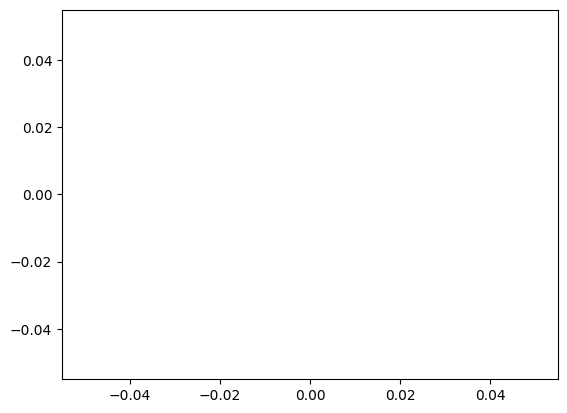

In [ ]:
plt.plot(shelters[shelters['capacity'] != -1]['capacity'].values)
plt.show()

In [ ]:
valid_shelters = shelters[shelters['capacity'] > -1]
valid_capacities = valid_shelters['capacity'].values
print(round((valid_shelters.shape[0] / shelters.shape[0]) * 100), '% of shelters have known capacities', sep='')

0% of shelters have known capacities


In [ ]:
def mean_without_outliers(array):
  try:
    q1 = np.percentile(array, 25)
    q3 = np.percentile(array, 75)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    array_no_outliers = array[(array >= lower_bound) & (array <= upper_bound)]
    return np.mean(array_no_outliers)
  except IndexError:
    print('There are no shelters with known capacities')

In [ ]:
print('Mean with outliers:', np.mean(valid_capacities))
print('Mean without outliers:', mean_without_outliers(valid_capacities))

Mean with outliers: nan
There are no shelters with known capacities
Mean without outliers: None


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Merge `populations` and `features`

In [ ]:
populations

,mesh_id,admin_code,2015,total,0-14,15-64,65+,75+,80+,prefecture
0,51376091,23231,11.9755,10.3920,1.1520,7.4451,1.7948,1.7948,1.7948,aichi
1,51376092,23231,49.9627,49.3347,3.9115,36.4093,9.0139,0.8471,0.0000,aichi
2,51376093,23231,198.4554,177.2314,13.2016,92.0688,71.9610,46.9480,32.7968,aichi
3,51377001,23231,4.9818,4.2682,1.4183,1.8501,0.9998,0.9998,0.9998,aichi
4,51377002,23231,74.7216,72.1030,8.4920,36.3534,27.2576,16.5906,5.1514,aichi
...,...,...,...,...,...,...,...,...,...,...
3958,53370030,23215,102.7384,85.4276,5.5384,36.9019,42.9874,22.3946,15.2843,aichi
3959,53370032,23215,1.0174,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,aichi
3960,53370040,23215,262.4544,227.7849,20.4748,112.0252,95.2849,55.7651,33.3713,aichi
3961,53370041,23215,5.0157,4.8221,0.0000,3.9171,0.9050,0.0000,0.0000,aichi


In [ ]:
all_features['mesh_id'] = all_features['mesh_id'].apply(int)
all_features

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water,shelter_count,shelter_capacity
0,52360600,34.66667,136.7500,1058695,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.8,0.0,0.2,0.000000,0,0
1,52360601,34.66667,136.7625,1058704,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000,0,0
2,52360602,34.66667,136.7750,1058714,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000,0,0
3,52360603,34.66667,136.7875,1058724,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000,0,0
4,52360604,34.66667,136.8000,1058734,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395,52375795,35.15833,137.9375,1053679,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1850.464128,0,0
25396,52375796,35.15833,137.9500,1053695,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1139.523258,0,0
25397,52375797,35.15833,137.9625,1053711,0.0,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.000000,0,0
25398,52375798,35.15833,137.9750,1053727,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1139.514408,0,0


In [ ]:
all_all_features = pd.merge(all_features, populations, on='mesh_id', how='inner')
all_features = all_all_features.sort_values(by='mesh_id')
all_features

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,...,shelter_capacity,admin_code,2015,total,0-14,15-64,65+,75+,80+,prefecture
0,52360679,34.72500,136.8625,1058050,0.00,0.00,0.000000,0.0,0.09,0.00,...,0,23445,137.8558,107.5152,6.5274,52.0045,48.9833,26.3348,16.9808,aichi
1,52360688,34.73333,136.8500,1057935,0.00,0.00,0.040000,0.0,0.00,0.00,...,0,23445,2.0045,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,aichi
2,52360689,34.73333,136.8625,1057946,0.08,0.03,0.190000,0.0,0.47,0.03,...,0,23445,1768.9284,1424.2370,123.8853,778.5919,521.7598,306.5540,198.5459,aichi
3,52360698,34.74167,136.8500,1057830,0.03,0.00,0.459999,0.0,0.09,0.00,...,0,23445,6.9975,6.2743,0.4863,1.3913,4.3968,0.6388,0.6388,aichi
4,52360699,34.74167,136.8625,1057841,0.07,0.11,0.749999,0.0,0.01,0.00,...,0,23445,939.9985,787.1743,75.9794,430.0539,281.1410,142.2526,79.6256,aichi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,53370030,35.35833,137.0000,1050127,0.25,0.07,0.580000,0.0,0.09,0.00,...,0,23215,102.7384,85.4276,5.5384,36.9019,42.9874,22.3946,15.2843,aichi
1294,53370032,35.35833,137.0250,1050149,0.00,0.49,0.490000,0.0,0.00,0.00,...,0,23215,1.0174,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,aichi
1295,53370040,35.36667,137.0000,1050020,0.21,0.02,0.670002,0.0,0.07,0.01,...,0,23215,262.4544,227.7849,20.4748,112.0252,95.2849,55.7651,33.3713,aichi
1296,53370041,35.36667,137.0125,1050031,0.06,0.00,0.840000,0.0,0.01,0.00,...,0,23215,5.0157,4.8221,0.0000,3.9171,0.9050,0.0000,0.0000,aichi


In [ ]:
m2 = folium.Map(location=[35.7015082, 139.5221197], zoom_start=10.3) # Higashi-Koganei station

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
prefs = list(set(all_features['prefecture']))

In [ ]:
for coord in zip(all_features['latitude'], all_features['longitude'], all_features['prefecture']):
  bottom_left = (coord[0], coord[1])
  top_right = (coord[0] + lat_width, coord[1] + lon_height)
  color = colors[prefs.index(coord[2])]
  folium.Rectangle(bounds=[bottom_left, top_right], color=None, fill=True, fill_color=color, fill_opacity=0.8).add_to(m2)

In [ ]:
m2

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# m2.save('kanto_map.html')

In [ ]:
all_features

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,...,shelter_capacity,admin_code,2015,total,0-14,15-64,65+,75+,80+,prefecture
0,52360679,34.72500,136.8625,1058050,0.00,0.00,0.000000,0.0,0.09,0.00,...,0,23445,137.8558,107.5152,6.5274,52.0045,48.9833,26.3348,16.9808,aichi
1,52360688,34.73333,136.8500,1057935,0.00,0.00,0.040000,0.0,0.00,0.00,...,0,23445,2.0045,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,aichi
2,52360689,34.73333,136.8625,1057946,0.08,0.03,0.190000,0.0,0.47,0.03,...,0,23445,1768.9284,1424.2370,123.8853,778.5919,521.7598,306.5540,198.5459,aichi
3,52360698,34.74167,136.8500,1057830,0.03,0.00,0.459999,0.0,0.09,0.00,...,0,23445,6.9975,6.2743,0.4863,1.3913,4.3968,0.6388,0.6388,aichi
4,52360699,34.74167,136.8625,1057841,0.07,0.11,0.749999,0.0,0.01,0.00,...,0,23445,939.9985,787.1743,75.9794,430.0539,281.1410,142.2526,79.6256,aichi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,53370030,35.35833,137.0000,1050127,0.25,0.07,0.580000,0.0,0.09,0.00,...,0,23215,102.7384,85.4276,5.5384,36.9019,42.9874,22.3946,15.2843,aichi
1294,53370032,35.35833,137.0250,1050149,0.00,0.49,0.490000,0.0,0.00,0.00,...,0,23215,1.0174,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,aichi
1295,53370040,35.36667,137.0000,1050020,0.21,0.02,0.670002,0.0,0.07,0.01,...,0,23215,262.4544,227.7849,20.4748,112.0252,95.2849,55.7651,33.3713,aichi
1296,53370041,35.36667,137.0125,1050031,0.06,0.00,0.840000,0.0,0.01,0.00,...,0,23215,5.0157,4.8221,0.0000,3.9171,0.9050,0.0000,0.0000,aichi


In [ ]:
all_features.to_pickle('data/aichi_features.pkl')